### Import & utils

In [ ]:
! pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def plot_arima_results(arima_res: ARIMAResultsWrapper, df: pd.core.frame.DataFrame, transform=lambda x:x, plot_train=True):
  d = max(arima_res.specification.get('k_diff'),
          arima_res.specification.get('k_seasonal_diff')*arima_res.specification.get('seasonal_periods'))
  n_train = len(arima_res.fittedvalues)
  forecast_steps = len(df) - n_train
  forecast = arima_res.get_forecast(forecast_steps)
  print(f'RMSE = {np.sqrt(np.mean((transform(forecast.predicted_mean.to_numpy()) - df.iloc[-forecast_steps:,0].to_numpy())**2)):.4f}')

  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(df.iloc[0 if plot_train else n_train:], label='data')
  if plot_train: ax.plot(df.index[d:n_train], arima_res.fittedvalues.iloc[d:].apply(transform), color='green', label='fitted')
  ax.plot(df.index[-forecast_steps:], forecast.predicted_mean.apply(transform), label='forecast')
  ax.fill_between(df.index[-forecast_steps:], *forecast.conf_int().apply(transform).to_numpy().transpose(), color='red', alpha=0.3)
  ax.legend()

def plot_pmdarima_results(arima: pm.arima.arima.ARIMA, df: pd.core.frame.DataFrame, transform=lambda x:x, plot_train=True):
  d = max(arima.order[1],
          arima.seasonal_order[1]*arima.seasonal_order[3])
  n_train = len(arima.fittedvalues())
  forecast_steps = len(df) - n_train
  forecast, confint = arima.predict(forecast_steps, return_conf_int=True)
  print(f'RMSE = {np.sqrt(np.mean((transform(forecast.to_numpy()) - df.iloc[-forecast_steps:,0].to_numpy())**2)):.4f}')

  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(df.iloc[0 if plot_train else n_train:], label='data')
  if plot_train: ax.plot(df.index[d:n_train], arima.fittedvalues().iloc[d:].apply(transform), color='green', label='fitted')
  ax.plot(df.index[-forecast_steps:], forecast.apply(transform), label='forecast')
  ax.fill_between(df.index[-forecast_steps:], *transform(confint).transpose(), color='red', alpha=0.3)
  ax.legend()

### Load data

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

--2022-09-19 18:35:47--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: ‘sp500sub.csv’

sp500sub.csv        100%[===================>]  24.29M   119MB/s    in 0.2s    

2022-09-19 18:35:47 (119 MB/s) - ‘sp500sub.csv’ saved [25473876/25473876]



In [ ]:
!head sp500sub.csv

Date,Open,High,Low,Close,Adj Close,Volume,Name
2010-01-04,9.220000267028807,9.510000228881836,9.170000076293944,9.5,9.5,1865400.0,INCY
2010-01-05,9.510000228881836,10.289999961853027,9.449999809265137,10.270000457763672,10.270000457763672,7608900.0,INCY
2010-01-06,10.380000114440918,11.09000015258789,10.350000381469727,11.0,11.0,8046700.0,INCY
2010-01-07,11.0,11.0600004196167,10.619999885559082,10.81999969482422,10.81999969482422,3680300.0,INCY
2010-01-08,10.81999969482422,11.0,10.75,10.9399995803833,10.9399995803833,1529300.0,INCY
2010-01-11,10.960000038146973,11.239999771118164,10.880000114440918,11.09000015258789,11.09000015258789,2280600.0,INCY
2010-01-12,10.989999771118164,11.0,10.34000015258789,10.359999656677246,10.359999656677246,4204600.0,INCY
2010-01-13,10.359999656677246,10.460000038146973,10.039999961853027,10.329999923706056,10.329999923706056,2134900.0,INCY
2010-01-14,10.3100004196167,10.390000343322754,10.079999923706056,10.15999984741211,10.15999984741211,2889600.0,INCY

In [ ]:
!tail sp500sub.csv

2018-12-14,44.20000076293945,44.2400016784668,43.4900016784668,43.54999923706055,42.1451301574707,6502000.0,MDLZ
2018-12-17,43.68999862670898,43.77000045776367,42.599998474121094,42.810001373291016,41.42900466918945,7848900.0,MDLZ
2018-12-18,42.9900016784668,43.20000076293945,41.86000061035156,42.13999938964844,40.780616760253906,10439500.0,MDLZ
2018-12-19,42.4900016784668,42.65999984741211,41.2400016784668,41.40999984741211,40.07416534423828,11258800.0,MDLZ
2018-12-20,41.38999938964844,41.599998474121094,40.5099983215332,41.15999984741211,39.83223342895508,11418300.0,MDLZ
2018-12-21,41.0,41.900001525878906,40.36999893188477,40.68000030517578,39.367713928222656,17481400.0,MDLZ
2018-12-24,40.72000122070313,40.849998474121094,39.20000076293945,39.47999954223633,38.20642471313477,6641300.0,MDLZ
2018-12-26,39.61999893188477,40.02999877929688,38.77999877929688,40.0,38.70965194702149,8640100.0,MDLZ
2018-12-27,39.790000915527344,40.2599983215332,39.18999862670898,40.22999954223633,38.93222808

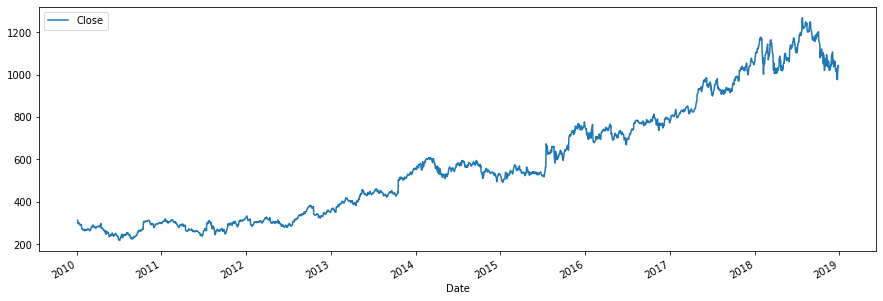

In [ ]:
df = pd.read_csv("sp500sub.csv", index_col='Date', parse_dates=True)
goog = df[df['Name'] == 'GOOG'][['Close']]
goog.plot(figsize=(15,5));

### Auto ARIMA (stepwise search)

In [ ]:
Ntest = 39  # last 2 months, from 2018-11-01 to 2018-12-28
target_col = 'Close'
model = pm.auto_arima(goog.iloc[:-Ntest][target_col], seasonal=False,
                      trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16143.220, Time=5.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16174.524, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16174.265, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16174.111, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16175.635, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16173.493, Time=1.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16173.330, Time=2.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16135.179, Time=4.76 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16169.981, Time=1.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=16135.248, Time=5.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16136.680, Time=6.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16135.405, Time=4.91 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16155.545, Time=2.78 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=16138.291, Time=6.47 sec
 ARIMA(3,1,2)(0,0,0

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2224
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -8060.589
Date:                Mon, 19 Sep 2022   AIC                          16135.179
Time:                        19:49:27   BIC                          16175.125
Sample:                             0   HQIC                         16149.768
                               - 2224                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8616      0.508      1.696      0.090      -0.134       1.857
ar.L1         -0.6502      0.026    -24.786      0.000      -0.702      -0.599
ar.L2         -0.9263      0.018    -50.562      0.000      -0.962      -0.890
ar.L3          0.0416      0.016      2.559      0.011       0.010       0.074
ma.L1          0.6898      0.021     32.961      0.000       0.649       0.731
ma.L2          0.9085      0.020     46.089      0.000       0.870       0.947
sigma2        82.5635      1.024     80.636      0.000      80.557      84.570
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11937.01
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               6.39   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


RMSE = 43.2030


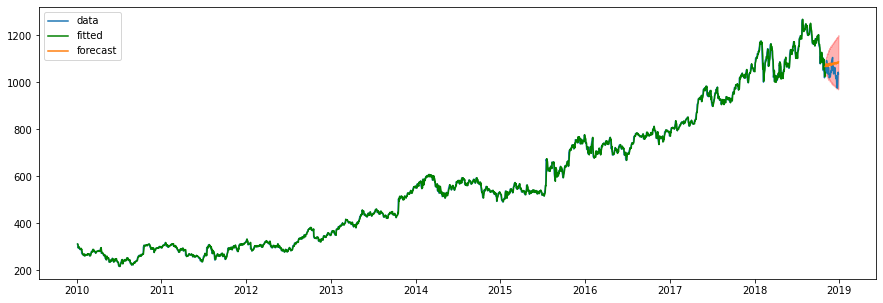

In [ ]:
plot_pmdarima_results(model, goog)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


RMSE = 43.2030


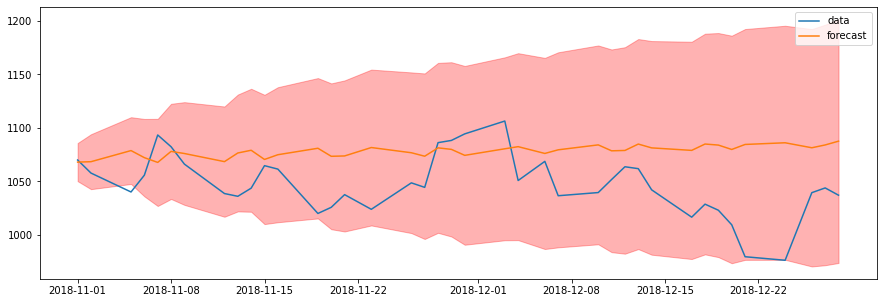

In [ ]:
plot_pmdarima_results(model, goog, plot_train=False)

In [ ]:
# Compare RMSE against naive forecast (= using last train data)
rmse = lambda x,y: np.sqrt(np.mean((x-y)**2))
print(f'RMSE (ARIMA) = {rmse(model.predict(Ntest).to_numpy(), goog.iloc[-Ntest:].to_numpy())}')
print(f'RMSE (Naive) = {rmse(goog.iloc[-Ntest-1].to_numpy(), goog.iloc[-Ntest:].to_numpy())}')

RMSE (ARIMA) = 41.797084950678716
RMSE (Naive) = 40.366003618696126


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


### Auto ARIMA (grid search)

In [ ]:
Ntest = 39  # last 2 months, from 2018-11-01 to 2018-12-28
target_col = 'Close'
model = pm.auto_arima(goog.iloc[:-Ntest][target_col], seasonal=False,
                      stepwise=False, max_order=5,
                      trace=True, suppress_warnings=True)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16174.524, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16174.111, Time=1.73 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16173.653, Time=1.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16168.820, Time=1.44 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=16170.810, Time=0.93 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=16157.099, Time=2.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16174.265, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16172.329, Time=1.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16173.493, Time=2.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16170.817, Time=2.24 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=16158.380, Time=3.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16174.228, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16173.330, Time=2.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16143.220, Time=5.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16135.405, Time=4.89

### ARIMA with adf, pacf, acf

In [ ]:
# ADF suggests d=1
print(f'p-value goog: {adfuller(goog)[1]}')
print(f'p-value goog.diff(): {adfuller(goog.diff().dropna())[1]}')

p-value goog: 0.9501019204142656
p-value goog.diff(): 1.706742922320762e-14


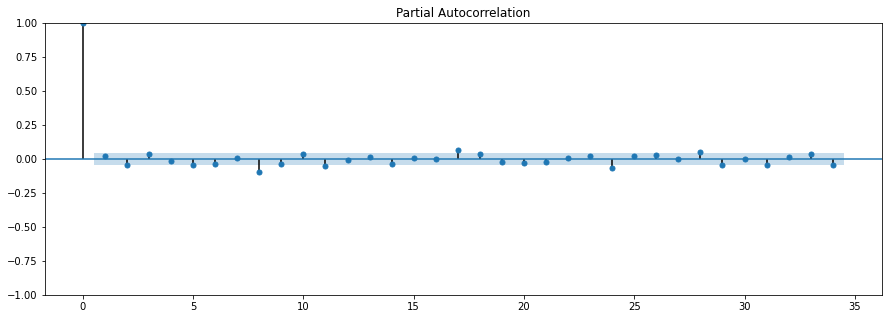

In [ ]:
# PACF plot suggests p=0
fig, ax = plt.subplots(figsize=(15,5))
plot_pacf(df.diff().dropna(), ax, method='ywm');

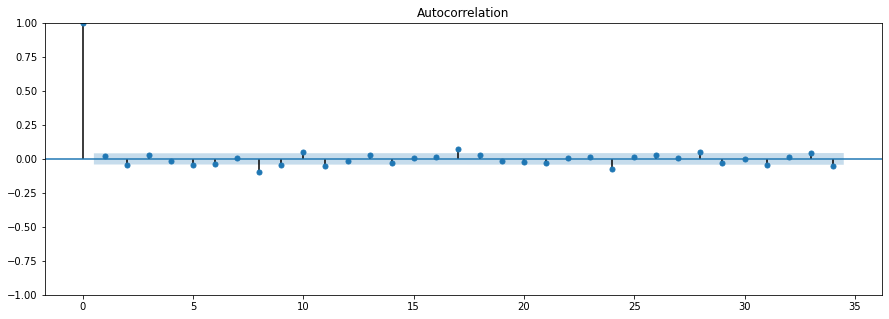

In [ ]:
# ACF plot suggests q=0
fig, ax = plt.subplots(figsize=(15,5))
plot_acf(df.diff().dropna(), ax);

We get ARIMA(0,1,0) ie. a random walk (sum of random noise). We also know that the best forecast for the random walk is the naive forecast.

In [ ]:
Ntest = 39  # last 2 months, from 2018-11-01 to 2018-12-28
target_col = 'Close'
arima = ARIMA(goog.iloc[:-Ntest][target_col], order=(0,1,0))
arima_res = arima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


RMSE = 40.3660


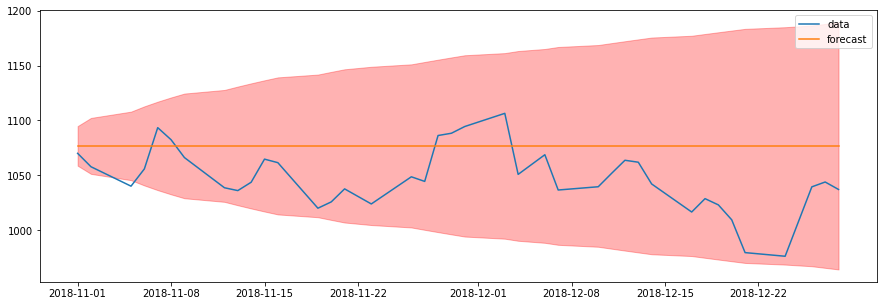

In [ ]:
plot_arima_results(arima_res, goog, plot_train=False)

In [ ]:
# Compare RMSE against naive forecast (= using last train data)
rmse = lambda x,y: np.sqrt(np.mean((x-y)**2))
print(f'RMSE (ARIMA) = {rmse(arima_res.forecast(Ntest).to_numpy(), goog.iloc[-Ntest:].to_numpy()):.4f}')
print(f'RMSE (Naive) = {rmse(goog.iloc[-Ntest-1].to_numpy(), goog.iloc[-Ntest:].to_numpy()):.4f}')

RMSE (ARIMA) = 40.3660
RMSE (Naive) = 40.3660


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
